## Data Processing

In [1]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [2]:
import os
import numpy as np

# Define paths
hr_dir = "/kaggle/input/gsoc-dataset-3b/Dataset/HR"
lr_dir = "/kaggle/input/gsoc-dataset-3b/Dataset/LR"
output_hr = "HR_new.npy"
output_lr = "LR_new.npy"

# Load and concatenate HR images
hr_files = sorted([f for f in os.listdir(hr_dir) if f.endswith('.npy')], key=lambda x: int(x.split('_')[1].split('.')[0]))
hr_data = [np.load(os.path.join(hr_dir, f)) for f in hr_files]
hr_array = np.stack(hr_data, axis=0)  # Stacking to create 4D array
np.save(output_hr, hr_array)
print(f"Saved {output_hr} with shape {hr_array.shape}")

# Load and concatenate LR images
lr_files = sorted([f for f in os.listdir(lr_dir) if f.endswith('.npy')], key=lambda x: int(x.split('_')[1].split('.')[0]))
lr_data = [np.load(os.path.join(lr_dir, f)) for f in lr_files]
lr_array = np.stack(lr_data, axis=0)  # Stacking to create 4D array
np.save(output_lr, lr_array)
print(f"Saved {output_lr} with shape {lr_array.shape}")

Saved HR_new.npy with shape (300, 1, 128, 128)
Saved LR_new.npy with shape (300, 1, 64, 64)


## Dataset Creation

In [3]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array): High-resolution images of shape (N, 1, 128, 128).
        - lr_images (numpy array): Low-resolution images of shape (N, 1, 64, 64).
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.
        Parameters:
        - idx (int): Index of the image to retrieve.
        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr

    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [4]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [5]:
hr_images.shape

(300, 1, 128, 128)

In [6]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
dataiter = iter(train_loader)
batch = next(dataiter)

hr_images = batch[1]
min_val = hr_images.min().item()
max_val = hr_images.max().item()

print(f"Min value: {min_val}, Max value: {max_val}")

Min value: 0.03535006567835808, Max value: 0.9423316121101379


## Model

In [8]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self, num_channels=1, num_blocks=16):
        super(Generator, self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        
        res_blocks = [ResidualBlock(64) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*res_blocks)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, num_channels, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        residual = x
        x = self.res_blocks(x)
        x = self.bn2(self.conv2(x))
        x += residual
        x = self.conv3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, num_channels=1):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.BatchNorm2d(out_channels),
            )
        
        self.model = nn.Sequential(
            discriminator_block(num_channels, 64, 1),
            discriminator_block(64, 64, 2),
            discriminator_block(64, 128, 1),
            discriminator_block(128, 128, 2),
            discriminator_block(128, 256, 1),
            discriminator_block(256, 256, 2),
            discriminator_block(256, 512, 1),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.model(x).view(batch_size))

## Train Function

In [9]:
import torch
from tqdm import tqdm
import torch.nn as nn
import os

def train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
                gen_optimizer, disc_optimizer, scheduler, device, num_epochs=30, save_dir='/kaggle/working/'):
    generator.to(device)
    discriminator.to(device)
    
    best_total_loss = float('inf')
    os.makedirs(save_dir, exist_ok=True)
    
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        running_g_loss = 0.0
        running_d_loss = 0.0
        total_batches = len(train_loader)
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for data in pbar:
            lr, hr = data[0].to(device), data[1].to(device)
            
            # Train Discriminator
            disc_optimizer.zero_grad()
            
            sr = generator(lr)
            real_output = discriminator(hr)
            fake_output = discriminator(sr.detach())
            
            d_loss_real = adversarial_criterion(real_output, torch.ones_like(real_output))
            d_loss_fake = adversarial_criterion(fake_output, torch.zeros_like(fake_output))
            d_loss = d_loss_real + d_loss_fake
            
            d_loss.backward()
            disc_optimizer.step()
            
            # Train Generator
            gen_optimizer.zero_grad()
            
            sr = generator(lr)
            fake_output = discriminator(sr)
            
            content_loss = content_criterion(sr, hr)
            adversarial_loss = adversarial_criterion(fake_output, torch.ones_like(fake_output))
            g_loss = content_loss + 1e-3 * adversarial_loss  # The factor 1e-3 balances the two losses
            
            g_loss.backward()
            gen_optimizer.step()
            
            running_g_loss += g_loss.item()
            running_d_loss += d_loss.item()
            
            pbar.set_postfix({'G_loss': f'{g_loss.item():.8f}', 'D_loss': f'{d_loss.item():.8f}'})
        
        # Step the scheduler after each epoch
        scheduler.step()
        
        # Calculate average losses for the epoch
        epoch_g_loss = running_g_loss / total_batches
        epoch_d_loss = running_d_loss / total_batches
        epoch_total_loss = epoch_g_loss + epoch_d_loss
        
        print(f'Epoch {epoch + 1}/{num_epochs}, G_Loss: {epoch_g_loss:.8f}, D_Loss: {epoch_d_loss:.8f}, Total Loss: {epoch_total_loss:.8f}')
        
        # Save the best model based on total loss
        if epoch_total_loss < best_total_loss:
            best_total_loss = epoch_total_loss
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'gen_optimizer_state_dict': gen_optimizer.state_dict(),
                'disc_optimizer_state_dict': disc_optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'g_loss': epoch_g_loss,
                'd_loss': epoch_d_loss,
                'total_loss': epoch_total_loss,
            }, os.path.join(save_dir, 'best_model.pth'))
            print(f'New best model saved with Total Loss: {epoch_total_loss:.8f}')
    
    print('Finished Training')


## Training

In [10]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.parallel import DataParallel



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


generator = Generator(num_channels=1)  
discriminator = Discriminator(num_channels=1) 


if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    generator = DataParallel(generator)
    discriminator = DataParallel(discriminator)

generator = generator.to(device)
discriminator = discriminator.to(device)


content_criterion = nn.L1Loss().to(device)
adversarial_criterion = nn.BCELoss().to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)


scheduler = StepLR(gen_optimizer, step_size=10, gamma=0.5)
train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
            gen_optimizer, disc_optimizer, scheduler, device)

Using device: cuda
Using 2 GPUs!


Epoch 1/30, G_Loss: 0.12144180, D_Loss: 0.99575757, Total Loss: 1.11719937
New best model saved with Total Loss: 1.11719937


Epoch 2/30, G_Loss: 0.03133663, D_Loss: 0.74882283, Total Loss: 0.78015946
New best model saved with Total Loss: 0.78015946


Epoch 3/30, G_Loss: 0.02989063, D_Loss: 0.66100959, Total Loss: 0.69090023
New best model saved with Total Loss: 0.69090023


Epoch 4/30, G_Loss: 0.02731952, D_Loss: 0.49229023, Total Loss: 0.51960974
New best model saved with Total Loss: 0.51960974


Epoch 5/30, G_Loss: 0.02338130, D_Loss: 0.53073512, Total Loss: 0.55411642


Epoch 6/30, G_Loss: 0.02601614, D_Loss: 0.11231418, Total Loss: 0.13833032
New best model saved with Total Loss: 0.13833032


Epoch 7/30, G_Loss: 0.02523072, D_Loss: 0.70419901, Total Loss: 0.72942973


Epoch 8/30, G_Loss: 0.02510402, D_Loss: 0.68580991, Total Loss: 0.71091393


Epoch 9/30, G_Loss: 0.02978442, D_Loss: 0.26075363, Total Loss: 0.29053805


Epoch 10/30, G_Loss: 0.02654746, D_Loss: 0.18677914, Total Loss: 0.21332660


Epoch 11/30, G_Loss: 0.02460110, D_Loss: 0.54435207, Total Loss: 0.56895317


Epoch 12/30, G_Loss: 0.02282518, D_Loss: 0.51997539, Total Loss: 0.54280057


Epoch 13/30, G_Loss: 0.02256698, D_Loss: 0.51516924, Total Loss: 0.53773622


Epoch 14/30, G_Loss: 0.02186433, D_Loss: 0.67727612, Total Loss: 0.69914045


Epoch 15/30, G_Loss: 0.02190756, D_Loss: 0.34357165, Total Loss: 0.36547920


Epoch 16/30, G_Loss: 0.03042987, D_Loss: 0.19540463, Total Loss: 0.22583450


Epoch 17/30, G_Loss: 0.02339098, D_Loss: 0.20618430, Total Loss: 0.22957527


Epoch 18/30, G_Loss: 0.02596982, D_Loss: 0.06242991, Total Loss: 0.08839973
New best model saved with Total Loss: 0.08839973


Epoch 19/30, G_Loss: 0.02901729, D_Loss: 0.12824844, Total Loss: 0.15726573


Epoch 20/30, G_Loss: 0.02538849, D_Loss: 0.10599921, Total Loss: 0.13138770


Epoch 21/30, G_Loss: 0.02515513, D_Loss: 0.10940535, Total Loss: 0.13456048


Epoch 22/30, G_Loss: 0.02513953, D_Loss: 0.12673144, Total Loss: 0.15187098


Epoch 23/30, G_Loss: 0.02490134, D_Loss: 0.04491475, Total Loss: 0.06981609
New best model saved with Total Loss: 0.06981609


Epoch 24/30, G_Loss: 0.02296156, D_Loss: 0.04554742, Total Loss: 0.06850898
New best model saved with Total Loss: 0.06850898


Epoch 25/30, G_Loss: 0.02493555, D_Loss: 0.04086237, Total Loss: 0.06579792
New best model saved with Total Loss: 0.06579792


Epoch 26/30, G_Loss: 0.02565122, D_Loss: 0.10586216, Total Loss: 0.13151339


Epoch 27/30, G_Loss: 0.02188816, D_Loss: 0.38366175, Total Loss: 0.40554992


Epoch 28/30, G_Loss: 0.01967238, D_Loss: 0.66133019, Total Loss: 0.68100258


Epoch 29/30, G_Loss: 0.02050057, D_Loss: 0.64888015, Total Loss: 0.66938072


Epoch 30/30, G_Loss: 0.02731062, D_Loss: 0.13517592, Total Loss: 0.16248654
Finished Training


In [11]:
train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
            gen_optimizer, disc_optimizer, scheduler, device)

Epoch 1/30, G_Loss: 0.02089279, D_Loss: 0.88109156, Total Loss: 0.90198435
New best model saved with Total Loss: 0.90198435


Epoch 2/30, G_Loss: 0.01763836, D_Loss: 0.71014474, Total Loss: 0.72778310
New best model saved with Total Loss: 0.72778310


Epoch 3/30, G_Loss: 0.01741492, D_Loss: 0.74163897, Total Loss: 0.75905389


Epoch 4/30, G_Loss: 0.01663941, D_Loss: 0.80136618, Total Loss: 0.81800559


Epoch 5/30, G_Loss: 0.01697239, D_Loss: 0.79350916, Total Loss: 0.81048154


Epoch 6/30, G_Loss: 0.01643183, D_Loss: 0.80830693, Total Loss: 0.82473876


Epoch 7/30, G_Loss: 0.01663497, D_Loss: 0.54105836, Total Loss: 0.55769334
New best model saved with Total Loss: 0.55769334


Epoch 8/30, G_Loss: 0.01763916, D_Loss: 0.48199873, Total Loss: 0.49963790
New best model saved with Total Loss: 0.49963790


Epoch 9/30, G_Loss: 0.01692380, D_Loss: 0.64983106, Total Loss: 0.66675486


Epoch 10/30, G_Loss: 0.01811003, D_Loss: 0.52739993, Total Loss: 0.54550996


Epoch 11/30, G_Loss: 0.01642648, D_Loss: 1.07818704, Total Loss: 1.09461352


Epoch 12/30, G_Loss: 0.01702995, D_Loss: 0.36952346, Total Loss: 0.38655341
New best model saved with Total Loss: 0.38655341


Epoch 13/30, G_Loss: 0.01833321, D_Loss: 0.09118287, Total Loss: 0.10951608
New best model saved with Total Loss: 0.10951608


Epoch 14/30, G_Loss: 0.01795813, D_Loss: 0.40167057, Total Loss: 0.41962870


Epoch 15/30, G_Loss: 0.01802819, D_Loss: 0.36127839, Total Loss: 0.37930659


Epoch 16/30, G_Loss: 0.01868457, D_Loss: 0.30513670, Total Loss: 0.32382127


Epoch 17/30, G_Loss: 0.01803034, D_Loss: 0.12071614, Total Loss: 0.13874648


Epoch 18/30, G_Loss: 0.01846643, D_Loss: 0.28011119, Total Loss: 0.29857761


Epoch 19/30, G_Loss: 0.01941799, D_Loss: 0.15379599, Total Loss: 0.17321399


Epoch 20/30, G_Loss: 0.01864135, D_Loss: 0.45981107, Total Loss: 0.47845242


Epoch 21/30, G_Loss: 0.01832940, D_Loss: 0.45114808, Total Loss: 0.46947747


Epoch 22/30, G_Loss: 0.01835685, D_Loss: 0.30458894, Total Loss: 0.32294579


Epoch 23/30, G_Loss: 0.01790668, D_Loss: 0.37104538, Total Loss: 0.38895207


Epoch 24/30, G_Loss: 0.01956755, D_Loss: 0.16530761, Total Loss: 0.18487516


Epoch 25/30, G_Loss: 0.01896450, D_Loss: 0.15277782, Total Loss: 0.17174233


Epoch 26/30, G_Loss: 0.01944027, D_Loss: 0.10938213, Total Loss: 0.12882239


Epoch 27/30, G_Loss: 0.02026963, D_Loss: 0.08862876, Total Loss: 0.10889839
New best model saved with Total Loss: 0.10889839


Epoch 28/30, G_Loss: 0.01718172, D_Loss: 1.22138327, Total Loss: 1.23856499


Epoch 29/30, G_Loss: 0.01651969, D_Loss: 1.02343517, Total Loss: 1.03995486


Epoch 30/30, G_Loss: 0.01617685, D_Loss: 0.90230636, Total Loss: 0.91848322
Finished Training


In [12]:
save_path = "/kaggle/working/Generator.pth"
torch.save(generator.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [13]:
save_path = "/kaggle/working/Discriminator.pth"
torch.save(discriminator.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [30]:
train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
            gen_optimizer, disc_optimizer, scheduler, device)

Epoch 1/30, G_Loss: 0.00827179, D_Loss: 0.00237070, Total Loss: 0.01064249
New best model saved with Total Loss: 0.01064249


Epoch 2/30, G_Loss: 0.00816800, D_Loss: 0.00321377, Total Loss: 0.01138177


Epoch 3/30, G_Loss: 0.00831172, D_Loss: 0.00168830, Total Loss: 0.01000002
New best model saved with Total Loss: 0.01000002


Epoch 4/30, G_Loss: 0.00833151, D_Loss: 0.00196013, Total Loss: 0.01029164


Epoch 5/30, G_Loss: 0.00893983, D_Loss: 0.00306464, Total Loss: 0.01200447


Epoch 6/30, G_Loss: 0.00939993, D_Loss: 0.00071642, Total Loss: 0.01011636


Epoch 7/30, G_Loss: 0.00978985, D_Loss: 0.00037812, Total Loss: 0.01016797


Epoch 8/30, G_Loss: 0.00969979, D_Loss: 0.00037031, Total Loss: 0.01007010


Epoch 9/30, G_Loss: 0.00970745, D_Loss: 0.00035015, Total Loss: 0.01005760


Epoch 10/30, G_Loss: 0.00982487, D_Loss: 0.00026822, Total Loss: 0.01009310


Epoch 11/30, G_Loss: 0.00987611, D_Loss: 0.00028551, Total Loss: 0.01016162


Epoch 12/30, G_Loss: 0.00997840, D_Loss: 0.00029933, Total Loss: 0.01027773


Epoch 13/30, G_Loss: 0.01014517, D_Loss: 0.00029240, Total Loss: 0.01043757


Epoch 14/30, G_Loss: 0.01179651, D_Loss: 0.00080243, Total Loss: 0.01259894


Epoch 15/30, G_Loss: 0.01139460, D_Loss: 0.00177022, Total Loss: 0.01316481


Epoch 16/30, G_Loss: 0.01030647, D_Loss: 0.02788146, Total Loss: 0.03818794


Epoch 17/30, G_Loss: 0.00955144, D_Loss: 0.00753848, Total Loss: 0.01708992


Epoch 18/30, G_Loss: 0.00987119, D_Loss: 0.00314483, Total Loss: 0.01301601


Epoch 19/30, G_Loss: 0.01010198, D_Loss: 0.00120116, Total Loss: 0.01130314


Epoch 20/30, G_Loss: 0.01022251, D_Loss: 0.03957902, Total Loss: 0.04980153


Epoch 21/30, G_Loss: 0.01041608, D_Loss: 0.01936132, Total Loss: 0.02977740


Epoch 22/30, G_Loss: 0.01062573, D_Loss: 0.00599392, Total Loss: 0.01661965


Epoch 23/30, G_Loss: 0.01200226, D_Loss: 0.00235176, Total Loss: 0.01435403


Epoch 24/30, G_Loss: 0.01019932, D_Loss: 0.00124707, Total Loss: 0.01144640


Epoch 25/30, G_Loss: 0.01027452, D_Loss: 0.00062287, Total Loss: 0.01089739


Epoch 26/30, G_Loss: 0.01039485, D_Loss: 0.00031709, Total Loss: 0.01071195


Epoch 27/30, G_Loss: 0.01033146, D_Loss: 0.00025908, Total Loss: 0.01059054


Epoch 28/30, G_Loss: 0.01045564, D_Loss: 0.00028231, Total Loss: 0.01073795


Epoch 29/30, G_Loss: 0.01075757, D_Loss: 0.00012926, Total Loss: 0.01088682


Epoch 30/30, G_Loss: 0.01104510, D_Loss: 0.01695203, Total Loss: 0.02799713
Finished Training


## Evaluation Metrics

In [14]:
import torch

def load_srgan_model(generator, discriminator, gen_optimizer, disc_optimizer, scheduler, device, model_path):
    checkpoint = torch.load(model_path, map_location=device)
    
    # Function to remove 'module.' prefix if it exists
    def remove_module_prefix(state_dict):
        return {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Load generator state dict
    gen_state_dict = remove_module_prefix(checkpoint['generator_state_dict'])
    generator.load_state_dict(gen_state_dict)

    # Load discriminator state dict
    disc_state_dict = remove_module_prefix(checkpoint['discriminator_state_dict'])
    discriminator.load_state_dict(disc_state_dict)
    
    gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
    disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])
    
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    epoch = checkpoint['epoch']
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    total_loss = checkpoint['total_loss']
    
    print(f"Loaded model from epoch {epoch}")
    print(f"Generator Loss: {g_loss:.8f}")
    print(f"Discriminator Loss: {d_loss:.8f}")
    print(f"Total Loss: {total_loss:.8f}")
    
    return generator, discriminator, gen_optimizer, disc_optimizer, scheduler, epoch

# Usage example:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00001)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=10, gamma=0.5)

model_path = '/kaggle/working/best_model.pth'
generator, discriminator, gen_optimizer, disc_optimizer, scheduler, epoch = load_srgan_model(
    generator, discriminator, gen_optimizer, disc_optimizer, scheduler, device, model_path
)

Loaded model from epoch 26
Generator Loss: 0.02026963
Discriminator Loss: 0.08862876
Total Loss: 0.10889839


<ipython-input-14-8a97616bcb76>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [15]:
!pip install pytorch_msssim

In [16]:
import torch
import torch.nn as nn
from tqdm import tqdm
from pytorch_msssim import ssim
import math

def evaluate_generator(generator, test_loader, device):
    generator.eval()
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    l1_scores = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating Generator"):
            lr, hr = data[0].to(device), data[1].to(device)
            sr = generator(lr)
            
            # Ensure sr and hr have the same size
            if sr.size() != hr.size():
                sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
            
            # Calculate metrics for each image in the batch
            for i in range(sr.size(0)):
                sr_img = sr[i].unsqueeze(0)
                hr_img = hr[i].unsqueeze(0)
                
                # MSE
                mse = mse_criterion(sr_img, hr_img).item()
                mse_scores.append(mse)
                
                # PSNR
                psnr = 10 * math.log10(1 / mse)
                psnr_scores.append(psnr)
                
                # SSIM
                ssim_score = ssim(sr_img, hr_img, data_range=1.0, size_average=False).item()
                ssim_scores.append(ssim_score)
                
                # L1 Loss
                l1_loss = l1_criterion(sr_img, hr_img).item()
                l1_scores.append(l1_loss)
    
    # Calculate average scores
    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)
    avg_l1 = sum(l1_scores) / len(l1_scores)
    
    return {
        'psnr': psnr_scores,
        'ssim': ssim_scores,
        'mse': mse_scores,
        'l1': l1_scores,
        'avg_psnr': avg_psnr,
        'avg_ssim': avg_ssim,
        'avg_mse': avg_mse,
        'avg_l1': avg_l1
    }


results = evaluate_generator(generator, test_loader, device)

print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Evaluating Generator: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

Average PSNR: 28.54
Average SSIM: 0.6521
Average MSE: 0.001557
Average L1 Loss: 0.034736


In [17]:
print(len(test_loader))

2


### Evaluation Results

In [18]:
print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Average PSNR: 28.54
Average SSIM: 0.6521
Average MSE: 0.001557
Average L1 Loss: 0.034736


## Visualization

Input shape (lr): torch.Size([16, 1, 128, 128])
Ground truth shape (hr): torch.Size([16, 1, 128, 128])
Model output shape (sr): torch.Size([16, 1, 128, 128])
Resized model output shape (sr): torch.Size([16, 1, 128, 128])


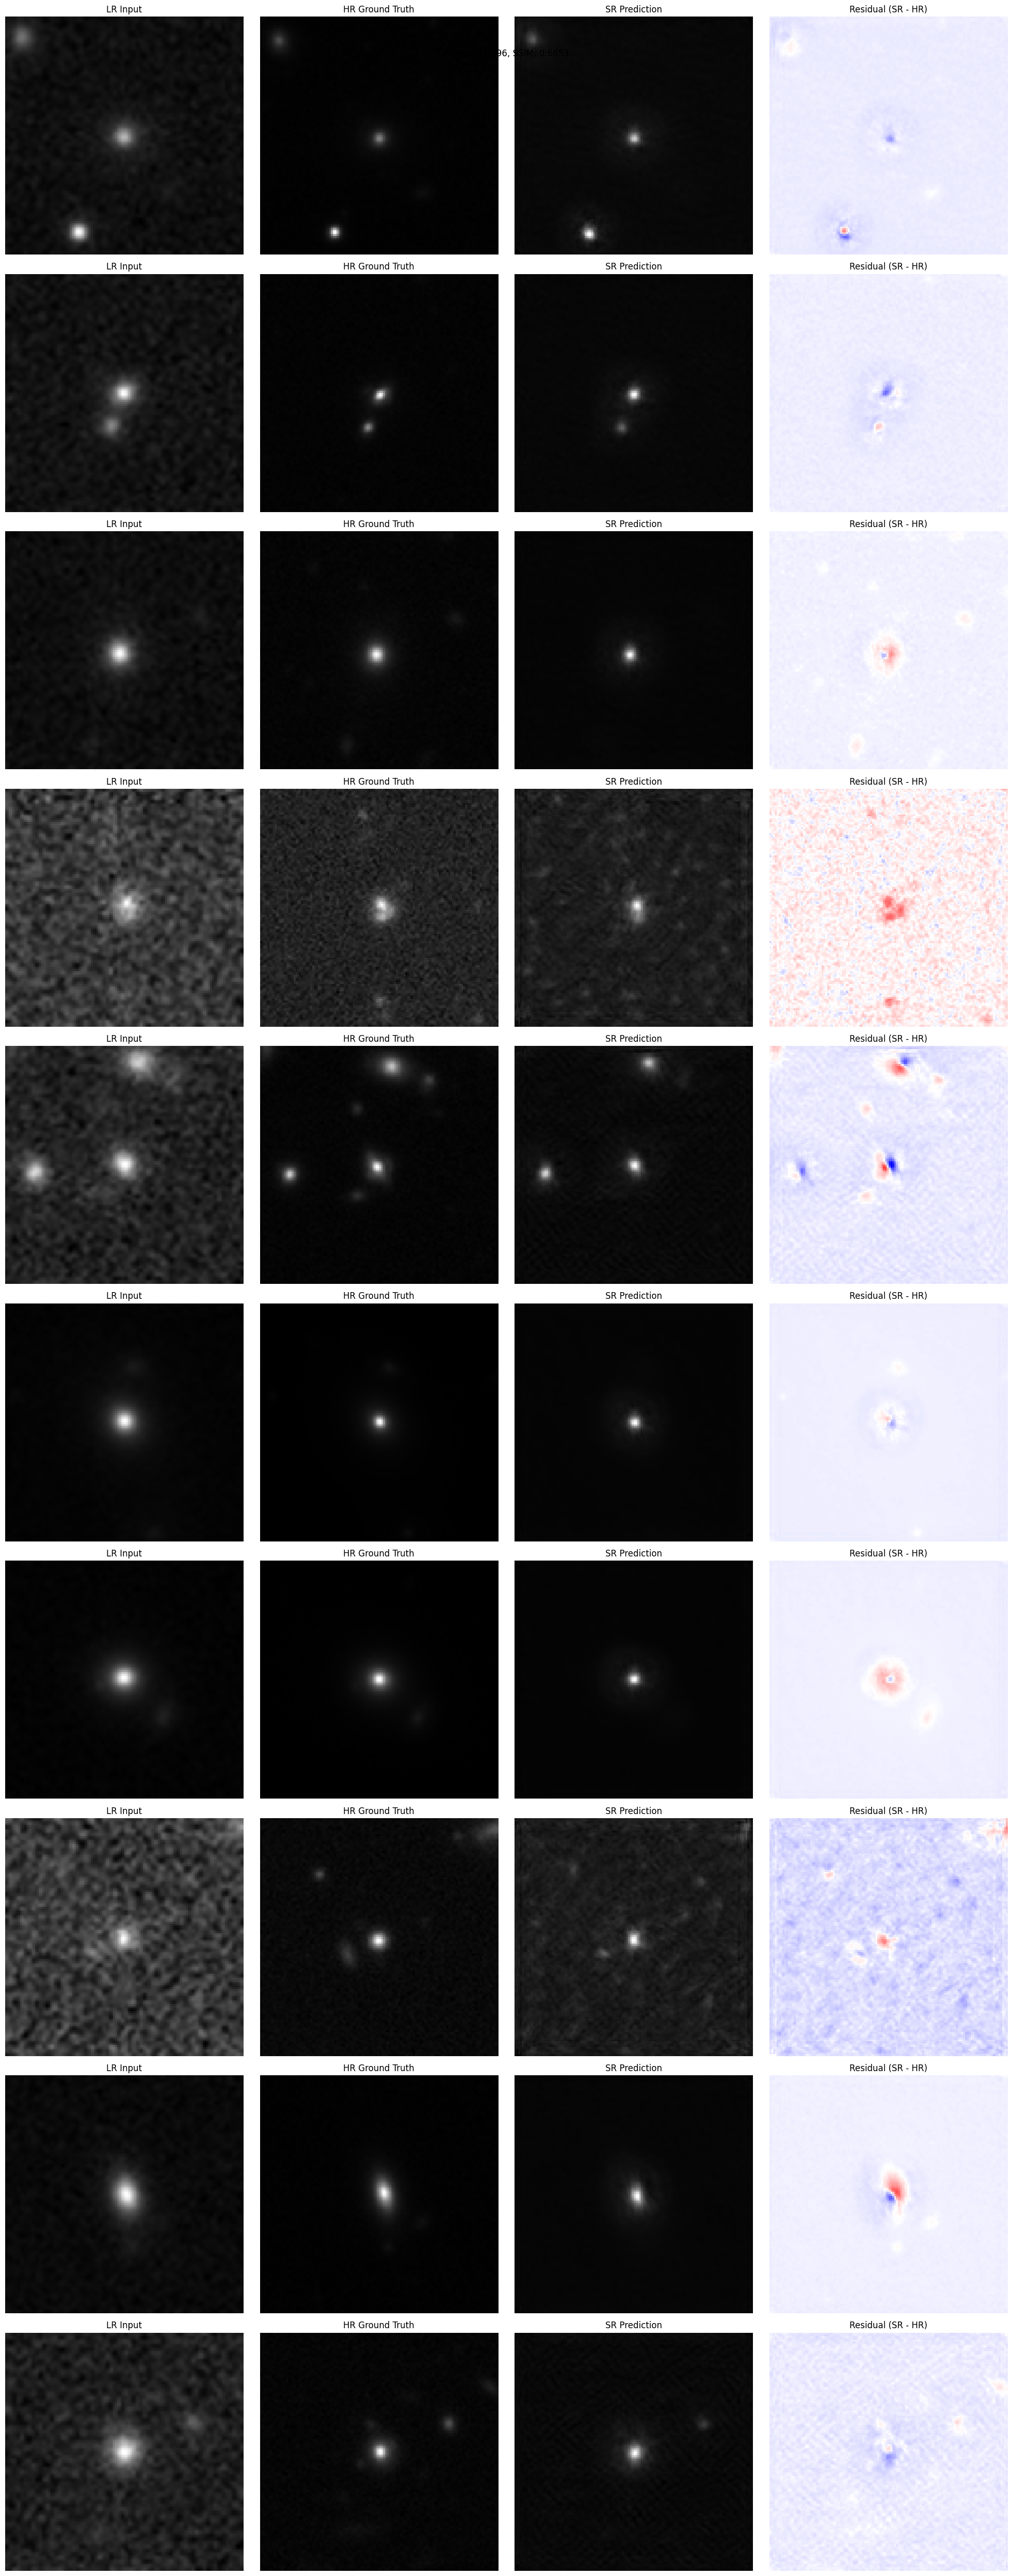

In [19]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def norma(x):
    return (x - x.min()) / (x.max() - x.min())

def plot_samples(model, test_loader, device, num_samples=10):
    model.eval()
    
    # Get a batch of images
    lr, hr = next(iter(test_loader))
    lr, hr = lr.to(device), hr.to(device)
    
    print(f"Input shape (lr): {lr.shape}")
    print(f"Ground truth shape (hr): {hr.shape}")
    
    with torch.no_grad():
        sr = model(lr)
    
    print(f"Model output shape (sr): {sr.shape}")
    
    # Ensure sr and hr have the same size
    if sr.size() != hr.size():
        sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
    
    print(f"Resized model output shape (sr): {sr.shape}")
    
    # Determine the number of samples to plot (minimum of batch size and num_samples)
    num_samples = min(lr.size(0), num_samples)
    
    # Calculate residuals
    residuals = hr - sr
    
    # Calculate metrics
    batch_psnr = []
    batch_ssim = []
    for i in range(num_samples):
        sr_np = norma(sr[i, 0].cpu().numpy())
        hr_np = norma(hr[i, 0].cpu().numpy())
        batch_psnr.append(psnr(hr_np, sr_np, data_range=1.0))
        batch_ssim.append(ssim(hr_np, sr_np, data_range=1.0))
    
    avg_psnr = np.mean(batch_psnr)
    avg_ssim = np.mean(batch_ssim)
    
    # Plot the images
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    # Ensure axes is always 2D, even when num_samples is 1
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # LR image
        axes[i, 0].imshow(lr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('LR Input')
        axes[i, 0].axis('off')
        # HR image
        axes[i, 1].imshow(hr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('HR Ground Truth')
        axes[i, 1].axis('off')
        # SR prediction
        axes[i, 2].imshow(sr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('SR Prediction')
        axes[i, 2].axis('off')
        # Residual map
        axes[i, 3].imshow(residuals[i, 0].cpu().numpy(), cmap='bwr', vmin=-0.5, vmax=0.5)
        axes[i, 3].set_title('Residual (SR - HR)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}')
    plt.show()

# Usage
plot_samples(generator, test_loader, device, num_samples=10)  # Requesting 10 samples
